In [1]:
import json
import seaborn as sns  
import dotenv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read function
def load_result_json(mapping_method, ood=False):
    ## create path
    path = f"data/results/almnps_{mapping_method}/"
    
    ## open ood or all
    if ood:
        path += "ood_validation.json"
    else:
        path += "all.json"
    
    ## open json file and read
    file = open(path, "r")
    results = json.load(file)
    file.close()
    
    return results

In [18]:
envs = dotenv.dotenv_values()
list_of_relations = envs["RELATION_LABELS"].split(" ")
list_of_relations.sort()

## load file 
results_for_method = load_result_json("embedding", ood=True)

# list of domians
domains = list(results_for_method.keys())[2:]

# create shape of array to use in functions 
shape_of_array = (len(list_of_relations), len(domains))

## Helper functions

In [30]:
def get_all_f1_scores(results):

    ## create empty array
    data = np.zeros(shape_of_array)

    ## loop over domains
    for i, domain in enumerate(domains):

        ## loop over relations    
        for j, relation in enumerate(list_of_relations):

            ## get f1 score and add to array
            data[j,i] = results[domain][relation]["f1-score"]
    
    return data

def get_total_support_for_domain(results, domain):
    
    total_support = 0
    
    ## loop over relations
    for relation in list_of_relations:
        
        ## get support for relation
        support = results[domain][relation]["support"]
        
        ## add to total support
        total_support += support
    
    return total_support

def weighted_f1_score(results):
    
    weighted_f1 = []

    ## get all f1 scores to use in calculations
    all_f1_scores = get_all_f1_scores(results)
    
    ## for each domains calculate weighted f1-score
    for i, domain in enumerate(domains):
        
        total_support = get_total_support_for_domain(results, domain)
        weighted_f1_domain = 0
        
        for j, relation in enumerate(list_of_relations):
            
            ## get support for relation
            support = results[domain][relation]["support"]

            if support == 0: # if support is 0, then f1-score is 0
                pass
            else: # if the relation is in the domain

                ## calculate weight
                weight = support / total_support
                
                ## get f1-score
                f1_relation = all_f1_scores[j][i]
                
                ## add to weighted f1-score
                weighted_f1_domain += weight * f1_relation

        weighted_f1.append(weighted_f1_domain)

    return weighted_f1    

def plot_weighted_f1_score_as_bar(results):
    weighted_f1 = weighted_f1_score(results)
    plt.figure(figsize=(10, 5))
    plt.bar(domains, weighted_f1)
    plt.title("Weighted F1-score for each domain")
    plt.xlabel("Domain")
    plt.ylabel("Weighted F1-score")
    plt.show()

def plot_heat_map(results, domains, transposed=False):
    data = get_all_f1_scores(results)
    plt.figure(figsize=(10, 5))
    if transposed:
        ax = sns.heatmap(data.transpose(), annot=True, cmap="YlGnBu" , xticklabels=list_of_relations, yticklabels=domains)
        ax.set_title("F1-score for each relation and domain")
        ax.set_xlabel("Relation")
        ax.set_ylabel("Domain")
    else:
        ax = sns.heatmap(data, annot=True, cmap="YlGnBu" , xticklabels=domains, yticklabels=list_of_relations)
        ax.set_title("F1-score for each relation and domain")
        ax.set_xlabel("Domain")
        ax.set_ylabel("Relation")
    plt.show()

def plot_heat_map_mapping_ood(mapping, transposed=False):
    ## load file 
    results_for_method = load_result_json(mapping, ood=True)
    # list of domains
    domains = list(results_for_method.keys())[2:]
    # plotting
    plot_heat_map(results_for_method, domains, transposed=transposed)

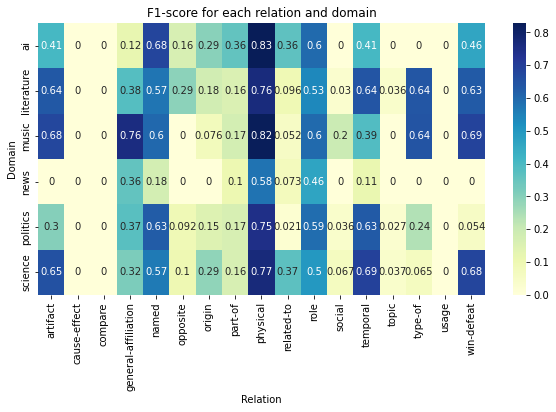

In [27]:
plot_heat_map(results_for_method, transposed=True, domains=domains)

In [7]:
weighted_f1 = weighted_f1_score(results_for_method)

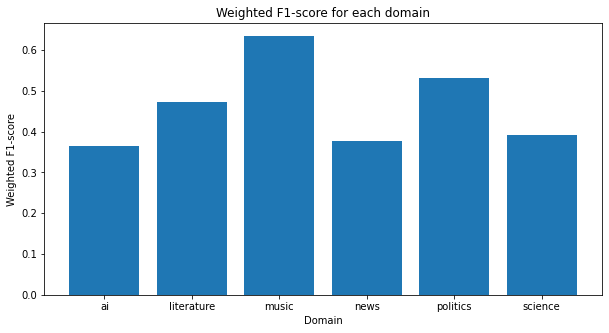

In [8]:
plot_weighted_f1_score_as_bar(results_for_method)

## OOD 

PLOT FOR  no_mapping


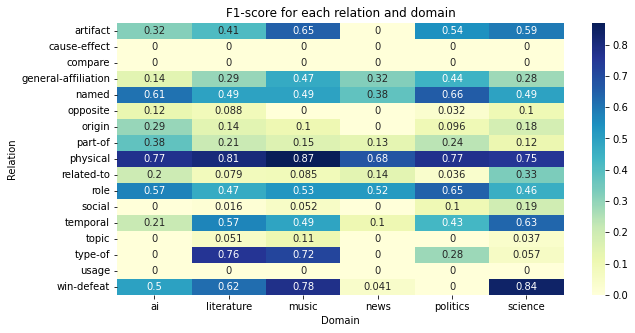

PLOT FOR  manual


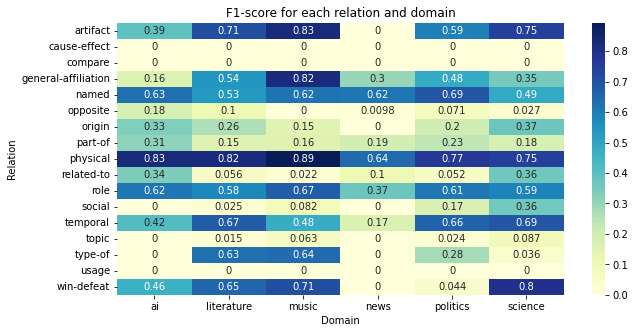

PLOT FOR  embedding


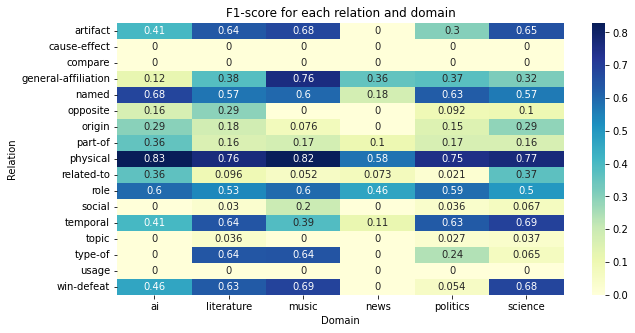

PLOT FOR  ood_clustering


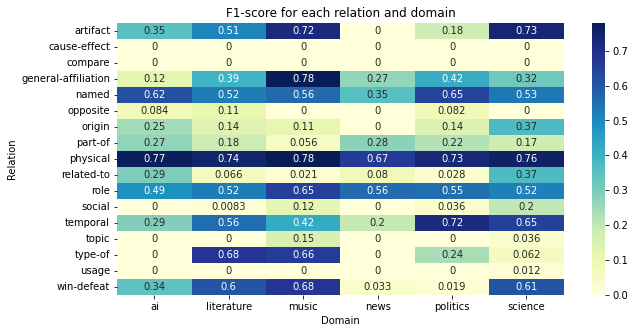

PLOT FOR  topological


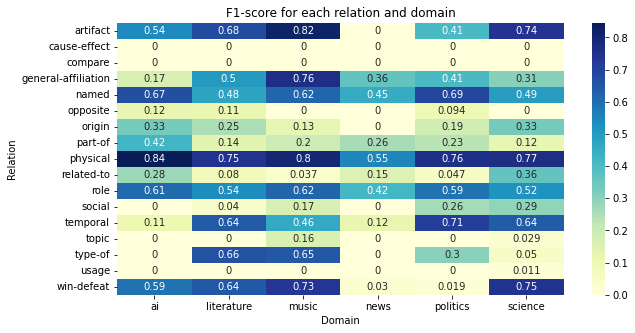

PLOT FOR  thesaurus_affinity


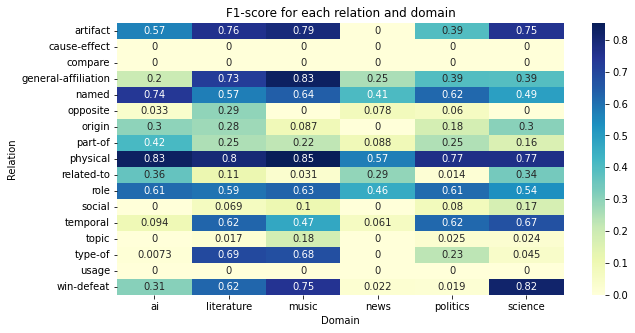

In [28]:
mapping_types = ["no_mapping", "manual", "embedding", "ood_clustering", "topological", "thesaurus_affinity"]
for m in mapping_types:
    print("Matrix For ", m)
    plot_heat_map_mapping_ood(m, ood=True, transposed=False)